In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Sequential, layers

In [5]:
import pathlib
data_dir=pathlib.Path('/home/017456972/.keras/datasets/flower_photos/')
data_dir

PosixPath('/home/017456972/.keras/datasets/flower_photos')

In [6]:
classes= [i.split('/')[-1]for i in [x[0] for x in os.walk(data_dir)][1:]]
classes

['roses', 'sunflowers', 'tulips', 'daisy', 'dandelion']

In [7]:
def laod_images_opencv_extisions(path):
    ext = [".jpg",".gif",".png",".tga",".webp"]   # Add image formats here
    files = []
    images = []
    [files.extend(data_dir.glob(path + '/*' + e)) for e in ext]
    return files

In [8]:
image_dir={}
for i in classes:
    image_dir[i]=laod_images_opencv_extisions(i)

Pre-Processing

In [9]:
import pandas as pd
import numpy as np

x, y = [], []
for category, image_paths in image_dir.items():
    for path in image_paths:
        try:
            x.append(path)
            y.append(category)
        except:
            continue

# Create a DataFrame from x and y
dataFrame = pd.DataFrame({
    'filename': x,
    'category': y
})


# Shuffle the DataFrame
dataFrame['category'] = dataFrame['category'].astype('string')
dataFrame['filename'] = dataFrame['filename'].astype('string')
dataFrame = dataFrame.sample(frac=1).reset_index(drop=True)

# Display the DataFrame
dataFrame.head()

,filename,category
0,/home/017456972/.keras/datasets/flower_photos/...,sunflowers
1,/home/017456972/.keras/datasets/flower_photos/...,sunflowers
2,/home/017456972/.keras/datasets/flower_photos/...,sunflowers
3,/home/017456972/.keras/datasets/flower_photos/...,tulips
4,/home/017456972/.keras/datasets/flower_photos/...,roses


In [10]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
dataFrame['category']=le.fit_transform(dataFrame['category'])
dataFrame['category'] = dataFrame['category'].astype('string')

# Display the DataFrame
dataFrame.head()

,filename,category
0,/home/017456972/.keras/datasets/flower_photos/...,3
1,/home/017456972/.keras/datasets/flower_photos/...,3
2,/home/017456972/.keras/datasets/flower_photos/...,3
3,/home/017456972/.keras/datasets/flower_photos/...,4
4,/home/017456972/.keras/datasets/flower_photos/...,2


In [11]:
dataFrame.head()

,filename,category
0,/home/017456972/.keras/datasets/flower_photos/...,3
1,/home/017456972/.keras/datasets/flower_photos/...,3
2,/home/017456972/.keras/datasets/flower_photos/...,3
3,/home/017456972/.keras/datasets/flower_photos/...,4
4,/home/017456972/.keras/datasets/flower_photos/...,2


In [12]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(dataFrame, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [13]:
type(train_df)

pandas.core.frame.DataFrame

In [14]:
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 5
batch_size = 16

In [15]:
dataFrame.category.unique()

<StringArray>
['3', '4', '2', '0', '1']
Length: 5, dtype: string

In [16]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
   
    x_col='filename',
    y_col='category',

    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2936 validated image filenames belonging to 5 classes.


In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
     
    x_col='filename',
    y_col='category',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 734 validated image filenames belonging to 5 classes.


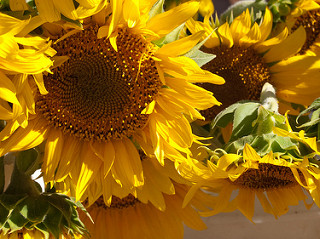

In [18]:
import PIL
PIL.Image.open(str(dataFrame['filename'][1]))

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
early_stopping=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)

VGG19 Model 

In [20]:
# Load the VGG19 model without the top layers
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the weights of the VGG19 layers
for layer in vgg19.layers:
    layer.trainable = False

# Build the custom model
vggModel = Sequential([
    vgg19,
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax'),
])

# Compile the model
vggModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
vggModel.summary()

2023-12-03 07:03:23.391191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-03 07:03:23.391277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coe-hpc1.sjsuad.sjsu.edu): /proc/driver/nvidia/version does not exist
2023-12-03 07:03:23.392970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 2

In [21]:
history1 = vggModel.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=total_validate//16,
    steps_per_epoch=total_train//16,callbacks=[checkpoint,early_stopping])

Epoch 1/20
183/183 [==============================] - 294s 2s/step - loss: 3.0981 - accuracy: 0.4575 - val_loss: 0.8295 - val_accuracy: 0.6847
Epoch 2/20
183/183 [==============================] - 287s 2s/step - loss: 1.3124 - accuracy: 0.4603 - val_loss: 1.1232 - val_accuracy: 0.5639
Epoch 3/20
183/183 [==============================] - 295s 2s/step - loss: 1.3405 - accuracy: 0.4041 - val_loss: 1.2353 - val_accuracy: 0.5569
Epoch 4/20
183/183 [==============================] - 295s 2s/step - loss: 1.3062 - accuracy: 0.4455 - val_loss: 0.8659 - val_accuracy: 0.6750
Epoch 5/20
183/183 [==============================] - 299s 2s/step - loss: 1.2202 - accuracy: 0.4890 - val_loss: 0.8777 - val_accuracy: 0.6792
Epoch 6/20
183/183 [==============================] - 300s 2s/step - loss: 1.1999 - accuracy: 0.5110 - val_loss: 0.8449 - val_accuracy: 0.7153
Epoch 7/20
183/183 [==============================] - 299s 2s/step - loss: 1.1828 - accuracy: 0.5127 - val_loss: 0.7705 - val_accuracy: 0.7472

In [47]:
test_loss, test_acc = vggModel.evaluate(validation_generator)
print('test accuracy : ', test_acc)

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']




46/46 [==============================] - 39s 786ms/step - loss: 0.7164 - accuracy: 0.7548
test accuracy :  0.7547683715820312


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


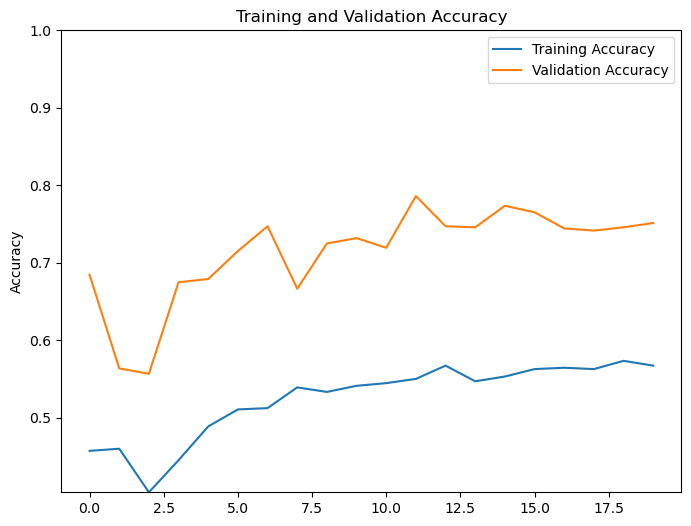

In [50]:
# plt.figure(figsize=(8, 8))
fig, ax = plt.subplots(figsize=(8, 6))  # Use plt.subplots() to create a figure and axes
ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')  # Use set_ylabel() instead of ylabel()
ax.set_ylim([min(min(acc), min(val_acc)), 1])  # Use set_ylim() instead of ylim()
ax.set_title('Training and Validation Accuracy')  # Use set_title() instead of title()
ax.legend()

# Save the figure after showing it
plt.savefig("vgg_accuracy.eps")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


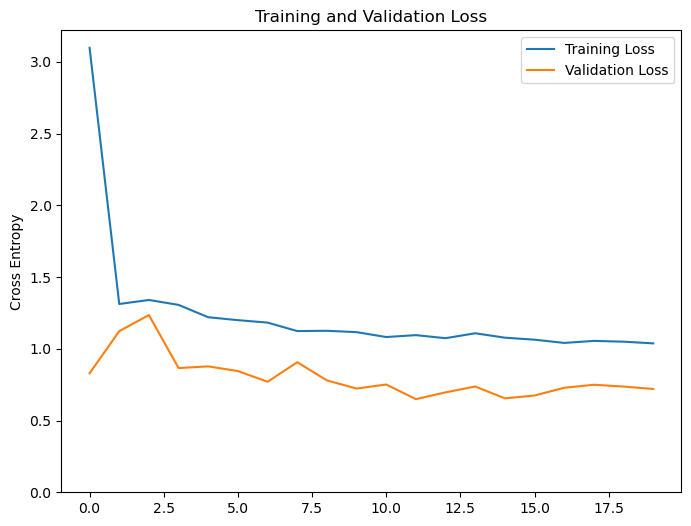

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.legend(loc='upper right')
ax.set_ylabel('Cross Entropy')
ax.set_ylim([0,max(plt.ylim())])
ax.set_title('Training and Validation Loss')

plt.savefig("vgg_loss.eps")

In [51]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=vggModel.predict(validation_generator)
valid_pred = [np.argmax(pred) for pred in valid_pres]
cm =confusion_matrix(validate_df['category'].astype('int'),valid_pred)
plt.figure(figsize = (8, 8))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


46/46 [==============================] - 38s 802ms/step


<Figure size 800x800 with 0 Axes>

              precision    recall  f1-score   support

           0       0.09      0.06      0.07       119
           1       0.24      0.23      0.23       188
           2       0.11      0.10      0.10       123
           3       0.15      0.12      0.13       149
           4       0.19      0.30      0.24       155

    accuracy                           0.17       734
   macro avg       0.16      0.16      0.16       734
weighted avg       0.17      0.17      0.17       734



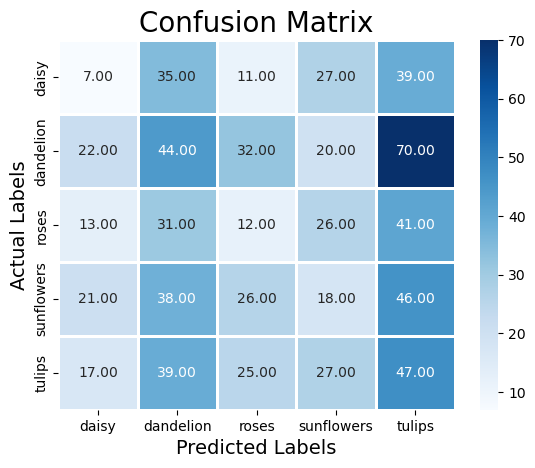

In [41]:
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

plt.savefig("vgg_conmat.eps")

# plt.show()
print(classification_report(validate_df['category'].astype('int32'),valid_pred))

InceptionV3

In [44]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model without the top layers
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the weights of the InceptionV3 layers
for layer in inception.layers:
    layer.trainable = False

# Build the custom model
incModel = Sequential([
    inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax'),
])

# Compile the model
incModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
incModel.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 23,906,085
Trainable params: 2,103,301
No

In [45]:
history2 = incModel.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=total_validate//16,
    steps_per_epoch=total_train//16,callbacks=[checkpoint,early_stopping])

Epoch 1/15
183/183 [==============================] - 65s 324ms/step - loss: 1.0146 - accuracy: 0.6825 - val_loss: 0.5159 - val_accuracy: 0.8028
Epoch 2/15
183/183 [==============================] - 58s 319ms/step - loss: 0.5941 - accuracy: 0.7818 - val_loss: 0.4439 - val_accuracy: 0.8417
Epoch 3/15
183/183 [==============================] - 58s 312ms/step - loss: 0.5098 - accuracy: 0.8164 - val_loss: 0.3691 - val_accuracy: 0.8653
Epoch 4/15
183/183 [==============================] - 57s 310ms/step - loss: 0.5212 - accuracy: 0.8137 - val_loss: 0.3633 - val_accuracy: 0.8569
Epoch 5/15
183/183 [==============================] - 57s 310ms/step - loss: 0.4927 - accuracy: 0.8154 - val_loss: 0.4292 - val_accuracy: 0.8250
Epoch 6/15
183/183 [==============================] - 57s 309ms/step - loss: 0.4529 - accuracy: 0.8295 - val_loss: 0.3650 - val_accuracy: 0.8625
Epoch 7/15
183/183 [==============================] - 56s 306ms/step - loss: 0.4584 - accuracy: 0.8298 - val_loss: 0.3842 - val_ac

In [52]:
test_loss, test_acc = incModel.evaluate(validation_generator)
print('test accuracy : ', test_acc)

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

46/46 [==============================] - 6s 123ms/step - loss: 0.3029 - accuracy: 0.8815
test accuracy :  0.8814713954925537


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


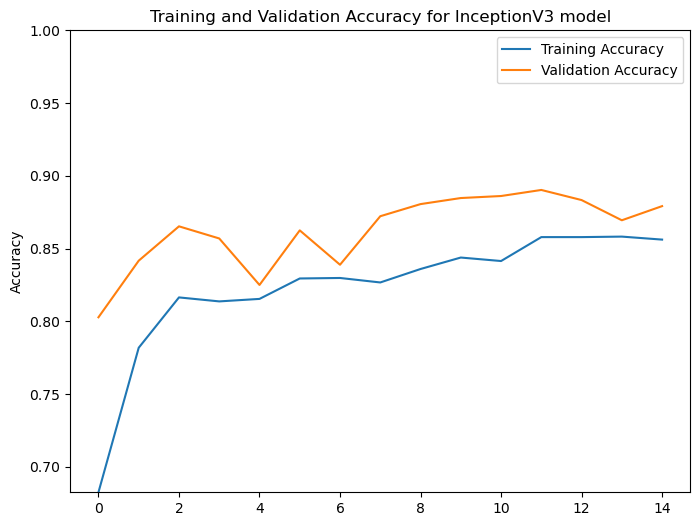

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))  # Use plt.subplots() to create a figure and axes
ax.plot(acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')  # Use set_ylabel() instead of ylabel()
ax.set_ylim([min(min(acc), min(val_acc)), 1])  # Use set_ylim() instead of ylim()
ax.set_title('Training and Validation Accuracy for InceptionV3 model')  # Use set_title() instead of title()
ax.legend()

# Save the figure after showing it
plt.savefig("inception_accuracy.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


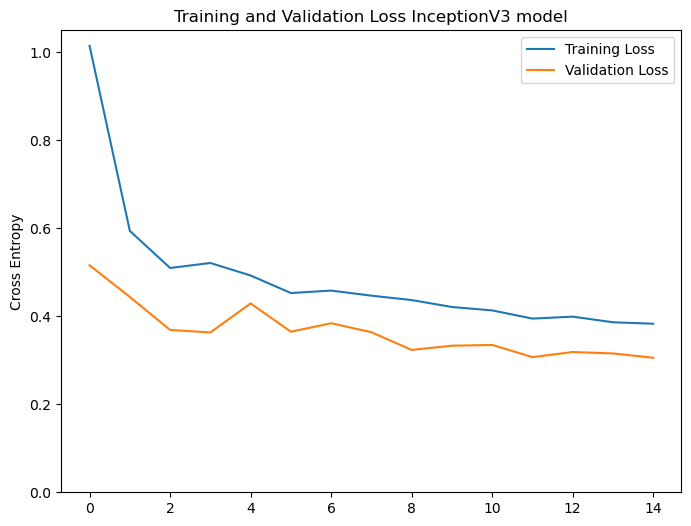

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.legend(loc='upper right')
ax.set_ylabel('Cross Entropy')
ax.set_ylim([0,max(plt.ylim())])
ax.set_title('Training and Validation Loss InceptionV3 model')

plt.savefig("Inception_loss.eps")

In [56]:
from sklearn.metrics import confusion_matrix,classification_report
valid_pres=incModel.predict(validation_generator)
valid_pred = [np.argmax(pred) for pred in valid_pres]
cm =confusion_matrix(validate_df['category'].astype('int'),valid_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])

46/46 [==============================] - 9s 160ms/step


<Figure size 1200x1000 with 0 Axes>

              precision    recall  f1-score   support

           0       0.17      0.17      0.17       119
           1       0.29      0.28      0.28       188
           2       0.13      0.12      0.13       123
           3       0.21      0.23      0.22       149
           4       0.23      0.23      0.23       155

    accuracy                           0.21       734
   macro avg       0.21      0.21      0.21       734
weighted avg       0.21      0.21      0.21       734



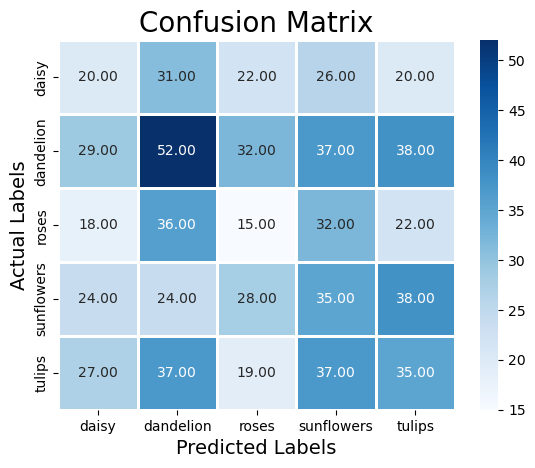

In [57]:
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

plt.savefig("inception_conmat.eps")

# plt.show()
print(classification_report(validate_df['category'].astype('int32'),valid_pred))

Save best model¶


In [58]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = incModel.to_json()
with open("Inception_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
incModel.save_weights("Inception_model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [61]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('Inception_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [62]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(validation_generator)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

46/46 [==============================] - 8s 125ms/step - loss: 0.3146 - accuracy: 0.8883
accuracy: 88.83%


1/1 [==============================] - 0s 236ms/step


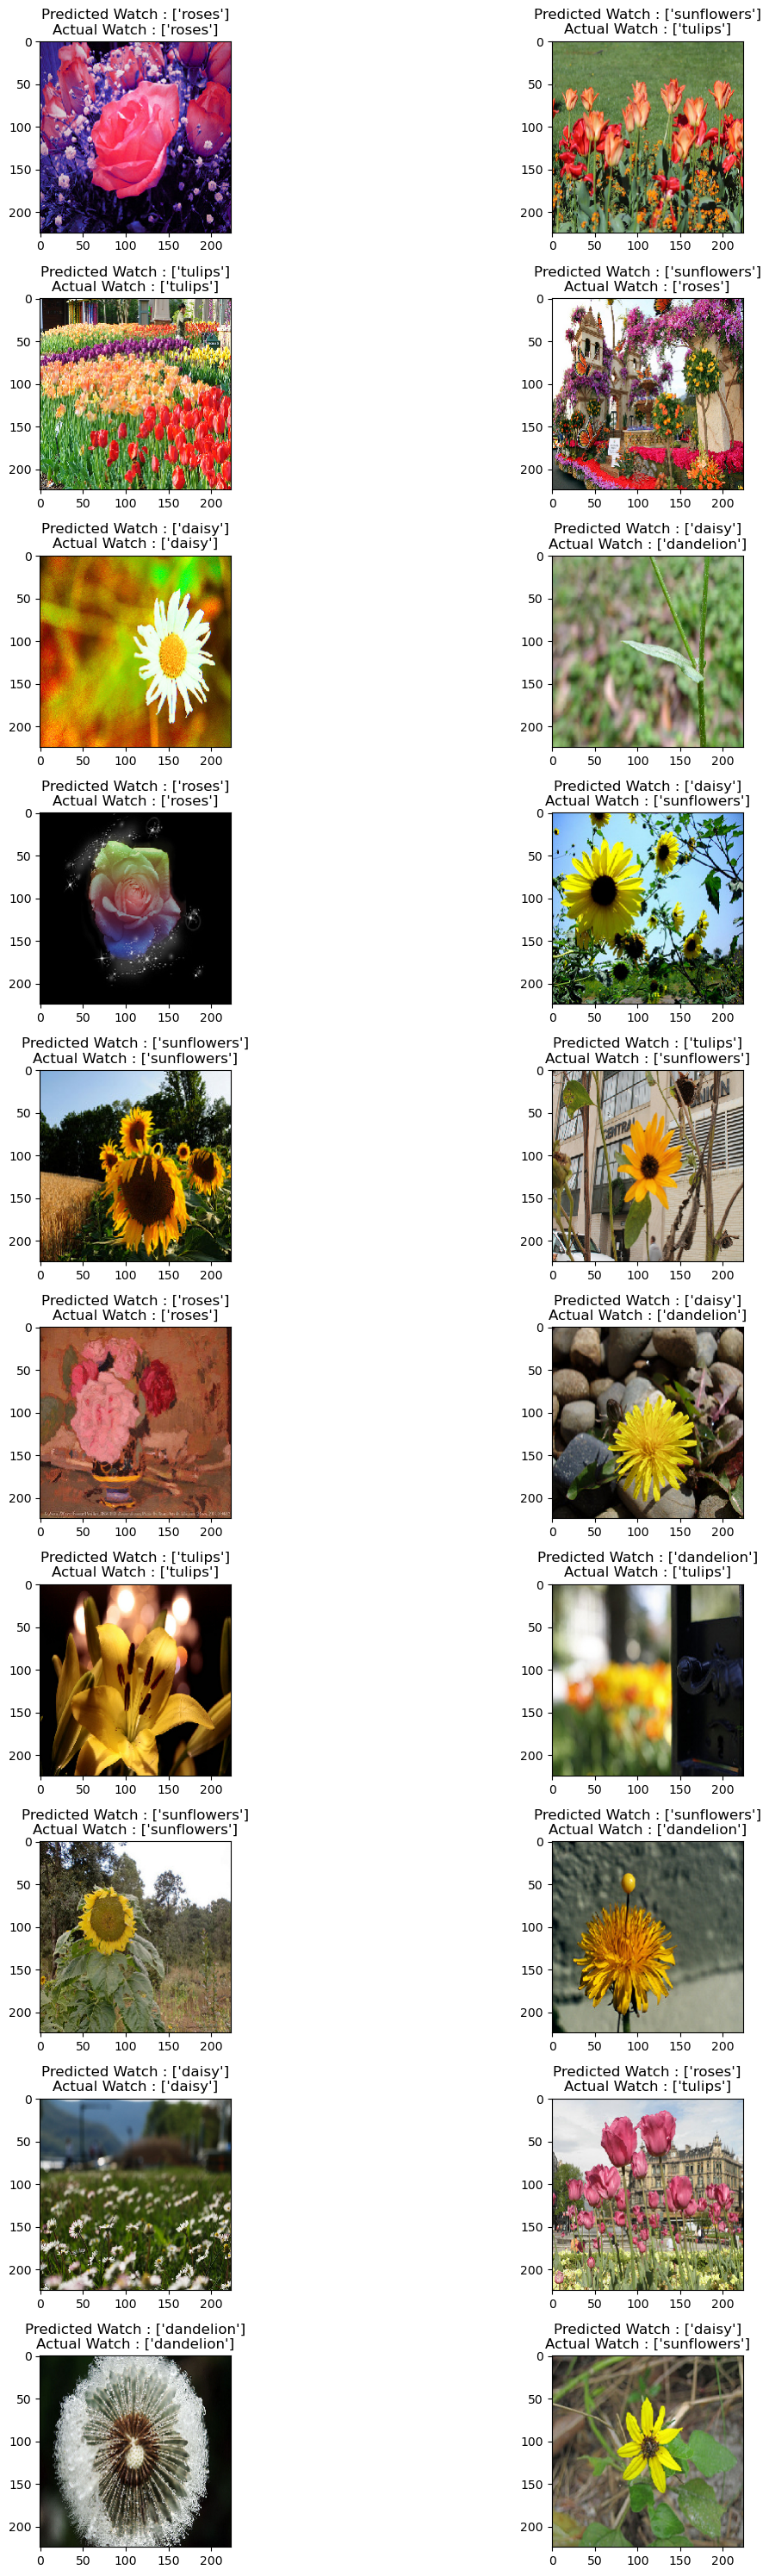

In [63]:
f, ax = plt.subplots(10, 2)
f.set_size_inches(15, 30)
count = 0
for x, y_true in validation_generator:
    y_pred = loaded_model.predict(x)
    y_pred_classes = np.argmax(y_pred, axis=1)
    for j in range(len(y_true)):
        if y_true[j][y_pred_classes[j]] == 1:
            ax[count, 0].imshow(x[j])
            ax[count, 0].set_title("Predicted Watch : "+str(le.inverse_transform([y_pred_classes[j]]))
                                   +"\n"+"Actual Watch : "+str(le.inverse_transform([np.argmax(y_true[j])])))
            count += 1
        if count == 10:
            break
    if count == 10:
        break

count = 0
for x, y_true in validation_generator:
    y_pred = loaded_model.predict(x)
    y_pred_classes = np.argmax(y_pred, axis=1)
    for j in range(len(y_true)):
        if y_true[j][y_pred_classes[j]] == 0:
            ax[count, 1].imshow(x[j])
            ax[count, 1].set_title("Predicted Watch : "+str(le.inverse_transform([y_pred_classes[j]]))
                                   +"\n"+"Actual Watch : "+str(le.inverse_transform([np.argmax(y_true[j])])))
            count += 1
        if count == 10:
            break
    if count == 10:
        break

plt.tight_layout()